In [34]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                   # Normaliza imágenes
    rotation_range=30,                # Rota ligeramente para variar perspectiva
    width_shift_range=0.15,           # Desplaza horizontalmente
    height_shift_range=0.15,          # Desplaza verticalmente
    shear_range=0.1,                  # Corta levemente para simular deformaciones
    zoom_range=[0.9, 1.1],            # Simula zoom in/out
    horizontal_flip=True,             # Refleja horizontalmente
    brightness_range=[0.8, 1.2],      # Simula distintas condiciones de luz
    fill_mode='nearest'               # Relleno de pixeles vacío
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size = (150, 150),
	batch_size = 8,  
	class_mode ='binary', 
	shuffle = True,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'
)

Found 508 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

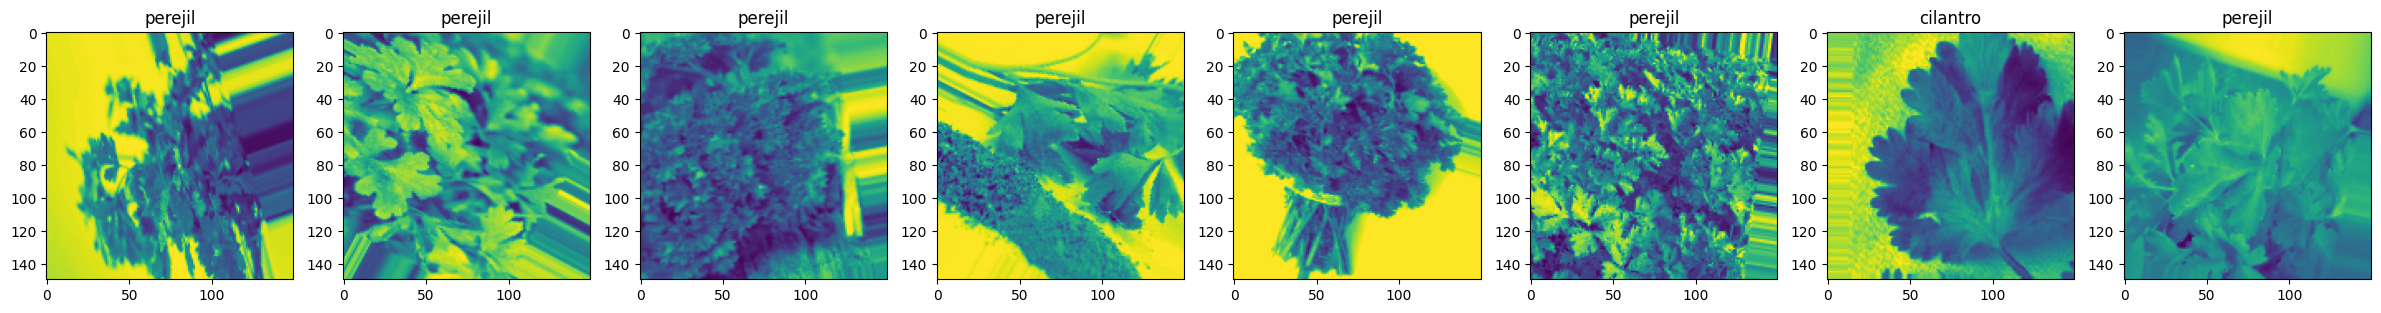

In [38]:
# Visualizar imágenes despúes de escalamiento y preprocesado
images, labels = train_generator[0]

class_names = list(train_generator.class_indices.keys()) # Obtener nombres de clases
label_indices = labels.astype(int)

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]):
    axarr[i].imshow(images[i].squeeze()) 
    axarr[i].set_title(class_names[label_indices[i]], fontsize=12)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras import optimizers


def get_model_deep(input_shape, num_classes=2):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [40]:
num_classes = train_generator.num_classes

model = get_model_deep((150, 150, 1), num_classes=num_classes)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 41472)             0         
                                                                 
 dense_12 (Dense)            (None, 32)               

In [42]:
def train_model_deep(model, train_generator, validation_generator):
    history = model.fit(train_generator, epochs=20, validation_data=validation_generator)
    return history
    
history = train_model_deep(model, train_generator, validation_generator)

Epoch 1/20
64/64 [==============================] - 4s 60ms/step - loss: 0.6769 - accuracy: 0.5807 - val_loss: 0.7540 - val_accuracy: 0.4754
Epoch 2/20
64/64 [==============================] - 4s 63ms/step - loss: 0.6771 - accuracy: 0.5472 - val_loss: 0.7548 - val_accuracy: 0.4754
Epoch 3/20
64/64 [==============================] - 4s 60ms/step - loss: 0.6709 - accuracy: 0.5965 - val_loss: 0.7859 - val_accuracy: 0.4918
Epoch 4/20
64/64 [==============================] - 4s 60ms/step - loss: 0.6894 - accuracy: 0.6024 - val_loss: 0.7587 - val_accuracy: 0.4590
Epoch 5/20
64/64 [==============================] - 4s 60ms/step - loss: 0.6759 - accuracy: 0.5866 - val_loss: 0.7934 - val_accuracy: 0.5246
Epoch 6/20
64/64 [==============================] - 4s 60ms/step - loss: 0.6666 - accuracy: 0.5906 - val_loss: 0.8211 - val_accuracy: 0.4754
Epoch 7/20
64/64 [==============================] - 4s 60ms/step - loss: 0.6696 - accuracy: 0.5768 - val_loss: 0.7813 - val_accuracy: 0.4426
Epoch 8/20
64

In [47]:
from sklearn.metrics import classification_report

# Obtener predicciones
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas verdaderas
y_true = test_generator.classes

# Nombres de clases
class_labels = list(test_generator.class_indices.keys())

# Reporte de métricas
print("Reporte:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

2/2 [==============================] - 1s 287ms/step
Reporte:

              precision    recall  f1-score   support

    cilantro       0.49      1.00      0.66        31
     perejil       0.00      0.00      0.00        32

    accuracy                           0.49        63
   macro avg       0.25      0.50      0.33        63
weighted avg       0.24      0.49      0.32        63



/Users/fridabg/Desktop/Cilantro-Perejil/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fridabg/Desktop/Cilantro-Perejil/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fridabg/Desktop/Cilantro-Perejil/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

2/2 [==============================] - 1s 301ms/step - loss: 0.8015 - accuracy: 0.3492


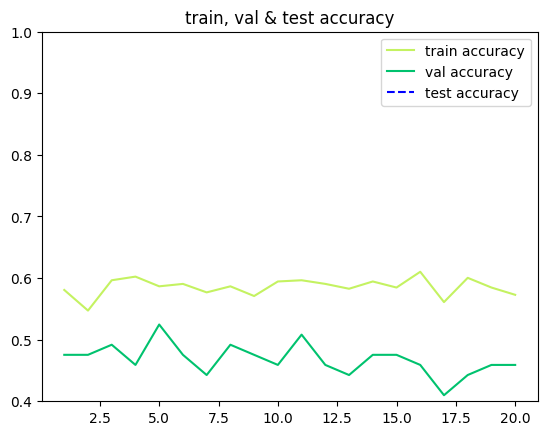

2/2 [==============================] - 1s 282ms/step - loss: 0.8015 - accuracy: 0.3492


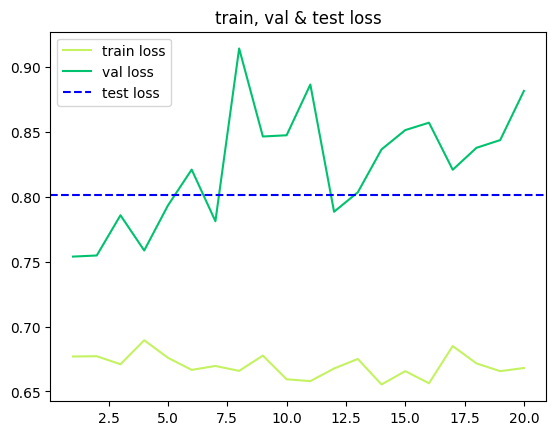

In [44]:
# Accuracy
test_loss, test_acc = model.evaluate(test_generator)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, color='#C4F261', label='train accuracy')
plt.plot(epochs, val_accuracy, color='#00C26E', label='val accuracy')
plt.axhline(y=test_acc, color='blue', linestyle='--', label='test accuracy')
plt.title('train, val & test accuracy')
plt.ylim(0.4, 1)
plt.legend()
plt.show()

# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

results = model.evaluate(test_generator)
test_loss = results[0]  

plt.figure()
plt.plot(epochs, train_loss, color='#C4F261', label='train loss')  
plt.plot(epochs, val_loss, color='#00C26E', label='val loss')     
plt.axhline(y=test_loss, color='blue', linestyle='--', label='test loss')

plt.title('train, val & test loss')
plt.legend()
plt.show()

2/2 [==============================] - 1s 273ms/step


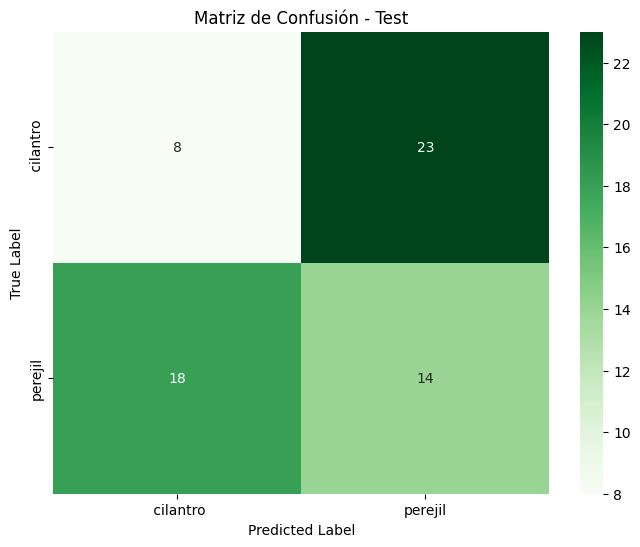

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obtener predicciones del modelo
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
# Obtener etiquetas verdaderas del generador
y_true = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()